In [1]:
import pygmt
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from obspy.clients.fdsn.client import Client
from obspy import read_inventory, UTCDateTime
import geojson
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

dyld[17558]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)


## Full figure

In [2]:
# EARTHQUAKES

filename = 'combined_catalog.csv'
data = pd.read_csv(filename)

lat = [data.iloc[i]['latitude'] for i in range(len(data))]
lon = [data.iloc[i]['longitude'] for i in range(len(data))]
mag = [np.log(data.iloc[i]['magnitude']) for i in range(len(data))]
name = [data.iloc[i]['catalog'] for i in range(len(data))]
dep = [data.iloc[i]['depth'] for i in range(len(data))]
cat_codes = []
for n in name:
    if n=='trehu':
        cat_codes.append(3)
    elif n=='morton':
        cat_codes.append(2)
    elif n=='stone':
        cat_codes.append(1)
    elif n=='pnsn':
        cat_codes.append(0)
    elif n=='anss':
        cat_codes.append(0)

osize = [i/12 for i in mag]
replacement_mag = np.nanmedian(osize)
new_osize = []
for o in osize:
    if np.isnan(o):
        new_osize.append(replacement_mag)
    else:
        new_osize.append(o)

osize = new_osize

#### Slab depths. Contour file for Slab2 available on the USGS website gives contours at 20 km. 

In [3]:
# Read in slab depths

with open("cas_slab2_dep_02.24.18_contours.in", 'r') as f:
    ls = f.readlines()
ds = {}; idd = 0
for l in ls:
    if l[0] == ">":
        idd += 1
        ds[idd] = []
    else:
        ds[idd].append([float(i) for i in l.split('\t')])
        


In [4]:
# Read in OOI cable route

# Cable:
filename = 'ooi_cables.csv'
cable = pd.read_csv(filename)
latt1 = [cable.iloc[i]['Lat'] for i in range(len(cable))]
lonn1 = [cable.iloc[i]['Long'] for i in range(len(cable))]

# Nodes:
ooi_py = [44.48146,44.36364,44.69139,45.755555]
ooi_px = [-125.14833,-124.96199,-124.45702,-127.278438]

ins_y = [44.5674,44.5096]
ins_x = [-125.1442,-125.3983]

In [5]:
# VLFE 

filename = 'VLFE_ghosh_etal.csv'
vlfe = pd.read_csv(filename)

VLFx =[-124.31746031746032,-124.58730158730158,-122.4126984126984]
VLFy =[47.78888888888889,45.666666666666664,43.36666666666667]

In [6]:
# Read in ONC cable route

# Cable:
with open('onc_cables.geoJson') as f:
    gj = geojson.load(f)
onc_coords = []
for feature in gj['features']:
    onc_coords.append(feature.geometry.coordinates[0])

# Nodes:
onc_py = [48.34590333,47.95836833,48.67453667,47.74129884,48.81321833]
onc_px = [-126.1580133,-129.0354383,-126.85251,-127.7294497,-125.2810783]


In [7]:
# GNSS-A
GNSS_y = [44.641,46.700,45.302,44.429,43.573]
GNSS_x = [-126.010,-125.401,-124.966,-125.194,-125.104]

Gx = [2.7661,2.5962,2.3335,2.0585,1.9282]
Gy = [2.1103,0.5737,1.956,1.9192,1.8465]

GNSS_yy = [48.56602716,48.283826,48.8299456,48.95258916,48.43093206,48.18414929]
GNSS_xx = [-127.1977728,-126.4561183,-127.4543846,-127.2676398,-126.1764366,-127.2311908]

Gxx=[]
Gyy=[]


In [8]:
fig = pygmt.Figure()
df = pd.DataFrame(
    data={
        "x": [-126.010,-125.401,-124.966,-125.194,-125.104],
        "y": [44.641,46.700,45.302,44.429,43.573],
        "east_velocity": [2.7661,2.5962,2.3335,2.0585,1.9282],
        "north_velocity": [2.1103,0.5737,1.956,1.9192,1.8465],
        "east_sigma": [0.15614, 0.468284, 0.822262, 0.508758, 0.972935],
        "north_sigma": [0.149423, 0.502172, 0.831643, 0.516072, 0.993238],
        "correlation_EN": [-0.00272129, -0.0133573, -0.00906105, -0.00499109, -0.0212995],
    }
)


dyld[17566]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)


In [29]:
fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-129, -121, 40, 50])
fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M10c", frame="a", cmap="earth", transparency = 50)

fig.colorbar(position = 'JMB+w7.+o.1c/1.c', frame='af+l"Elevation (m)"')
pygmt.makecpt(cmap="lock.cpt")
fig.grdimage(grid='Fig8b_locking_degree_lock.grd',projection="M10c",cmap=True,transparency = 40,nan_transparent=True)
fig.colorbar(position = 'JMR+w/5.+o0.5c/-5.c', frame='af+l"Plate locking"')

fig.grdcontour(interval=200,limit =[-220, 0], grid=grid, pen='0.1p,black')
fig.grdcontour(interval=2000,limit =[-2200, 0], grid=grid,pen='0.1p,black')

# Plot earthquakes
pygmt.makecpt(cmap="cyclic",series='0/3/1',reverse=False,color_model='+cRegional,Stone,Morton,Trehu',verbose='q')
fig.plot(x = lon, y = lat, size = osize,color = cat_codes,cmap = True, style = "c", pen = "black")
fig.colorbar(position = 'JMR+w/5.+o0.5c/5.c')

# Plot slab depths, as 2 km contours
#pygmt.makecpt(cmap="hot", series=[-500, 0, 20], color_model="+c0-9",reverse=True)
for idd in ds:
    d = np.array(ds[idd])
    if d[0, 2] % 2 ==0:
        #fig.plot(x = d[:, 0] - 360, y = d[:, 1], cmap = True, zvalue = d[0, 2], pen = '1.p')
        fig.plot(x = d[:, 0] - 360, y = d[:, 1], pen = '0.75p,--')

# Plot VLFE
fig.plot(x=vlfe['Longitude'],y=vlfe['Latitude'],style="a0.3c", pen="0.5p,black", color="green")
fig.plot(x=VLFx,y=VLFy,style="a0.3c", pen="0.5p,black", color="blue")

# Plot OOI Cable
fig.plot(x=lonn1[0:333],y=latt1[0:333],pen = "1.3p,black")
fig.plot(x=lonn1[333:500],y=latt1[333:500],pen = "1.3p,black")
fig.plot(x=ooi_px[0], y=ooi_py[0], style="s0.15c", pen="0.5p,black", color="red")
fig.plot(x=ooi_px[1], y=ooi_py[1], style="s0.15c", pen="0.5p,black", color="red")
fig.plot(x=ooi_px[2], y=ooi_py[2], style="s0.15c", pen="0.5p,black", color="red")
fig.plot(x=ooi_px[3], y=ooi_py[3], style="s0.15c", pen="0.5p,black", color="black")
fig.plot(x=ins_x[0], y=ins_y[0], style="t0.15c", pen="0.5p,black", color="gold")
fig.plot(x=ins_x[1], y=ins_y[1], style="s0.15c", pen="0.5p,black", color="gold")

# Plot ONC cable
for coord_list in onc_coords:
    clats = [c[1] for c in coord_list]
    clons = [c[0] for c in coord_list]
    fig.plot(x=clons,y=clats,pen = "1.5p,black")
fig.plot(x=onc_px, y=onc_py, style="s0.2c", pen="0.5p,black", color="black")
fig.plot(x=GNSS_x, y=GNSS_y, style="t0.2c", pen="0.5p,black", color="white")
fig.plot(x=GNSS_xx, y=GNSS_yy, style="t0.2c", pen="0.5p,black", color="white")
fig.plot(x=lonn1[332],y=latt1[332],style="t0.15c", pen="0.5p,black", color="red")

fig.coast(borders=["a/0.75p,black","2/0.75p,black"],shorelines=["0.5p,black",".5p,black"],transparency=1)

fig.velo(
    data=df,
    region=[-129, -121, 40, 50],
    pen="0.6p,black",
    line=True,
    spec="e0.2/0.39/18",
    vector="0.3c+p1p+e+gblack",
)

fig.basemap(projection="M10c",region=[-129, -121, 40, 50],map_scale="n0.12/0.045+l+c128.5/34.95+w100k",box='+gwhite',frame=True)
#map_scale="jBL+w5k+o0.2c/0.5c+f+lkm"
fig.plot(
    x=-121.5,
    y=49.5,
    style="r0.8c/1.2c",  # rectangle
    color="white",  # fill color
    pen="0.6p,black",  # outline thickness and color
)
# plot legend
fig.plot(x = [-121.6], y = [49.7], size = [3/12],color = "white", style = "c", pen = "black")
fig.plot(x = [-121.6], y = [49.5], size = [2/12],color = "white", style = "c", pen = "black")
fig.plot(x = [-121.6], y = [49.3], size = [1/12],color = "white", style = "c", pen = "black")


# add annotations
fig.text(
    font="7.5p",
    text="3",
    x=[-121.35],
    y=[49.7],
)
fig.text(
    font="7.5p",
    text="2",
    x=[-121.35],
    y=[49.5],
)
fig.text(
    font="7.5p",
    text="1",
    x=[-121.35],
    y=[49.3],
)

dyld[18580]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18581]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
dyld[18582]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no suc

dyld[18611]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18612]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18613]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18614]: Library not loaded: '/usr/local/opt/net

dyld[18638]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18639]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18640]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18641]: Library not loaded: '/usr/local/opt/net

dyld[18667]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18668]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18669]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18670]: Library not loaded: '/usr/local/opt/net

dyld[18701]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18702]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18703]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18704]: Library not loaded: '/usr/local/opt/net

dyld[18728]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18729]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18730]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)


dyld[18731]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18732]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)


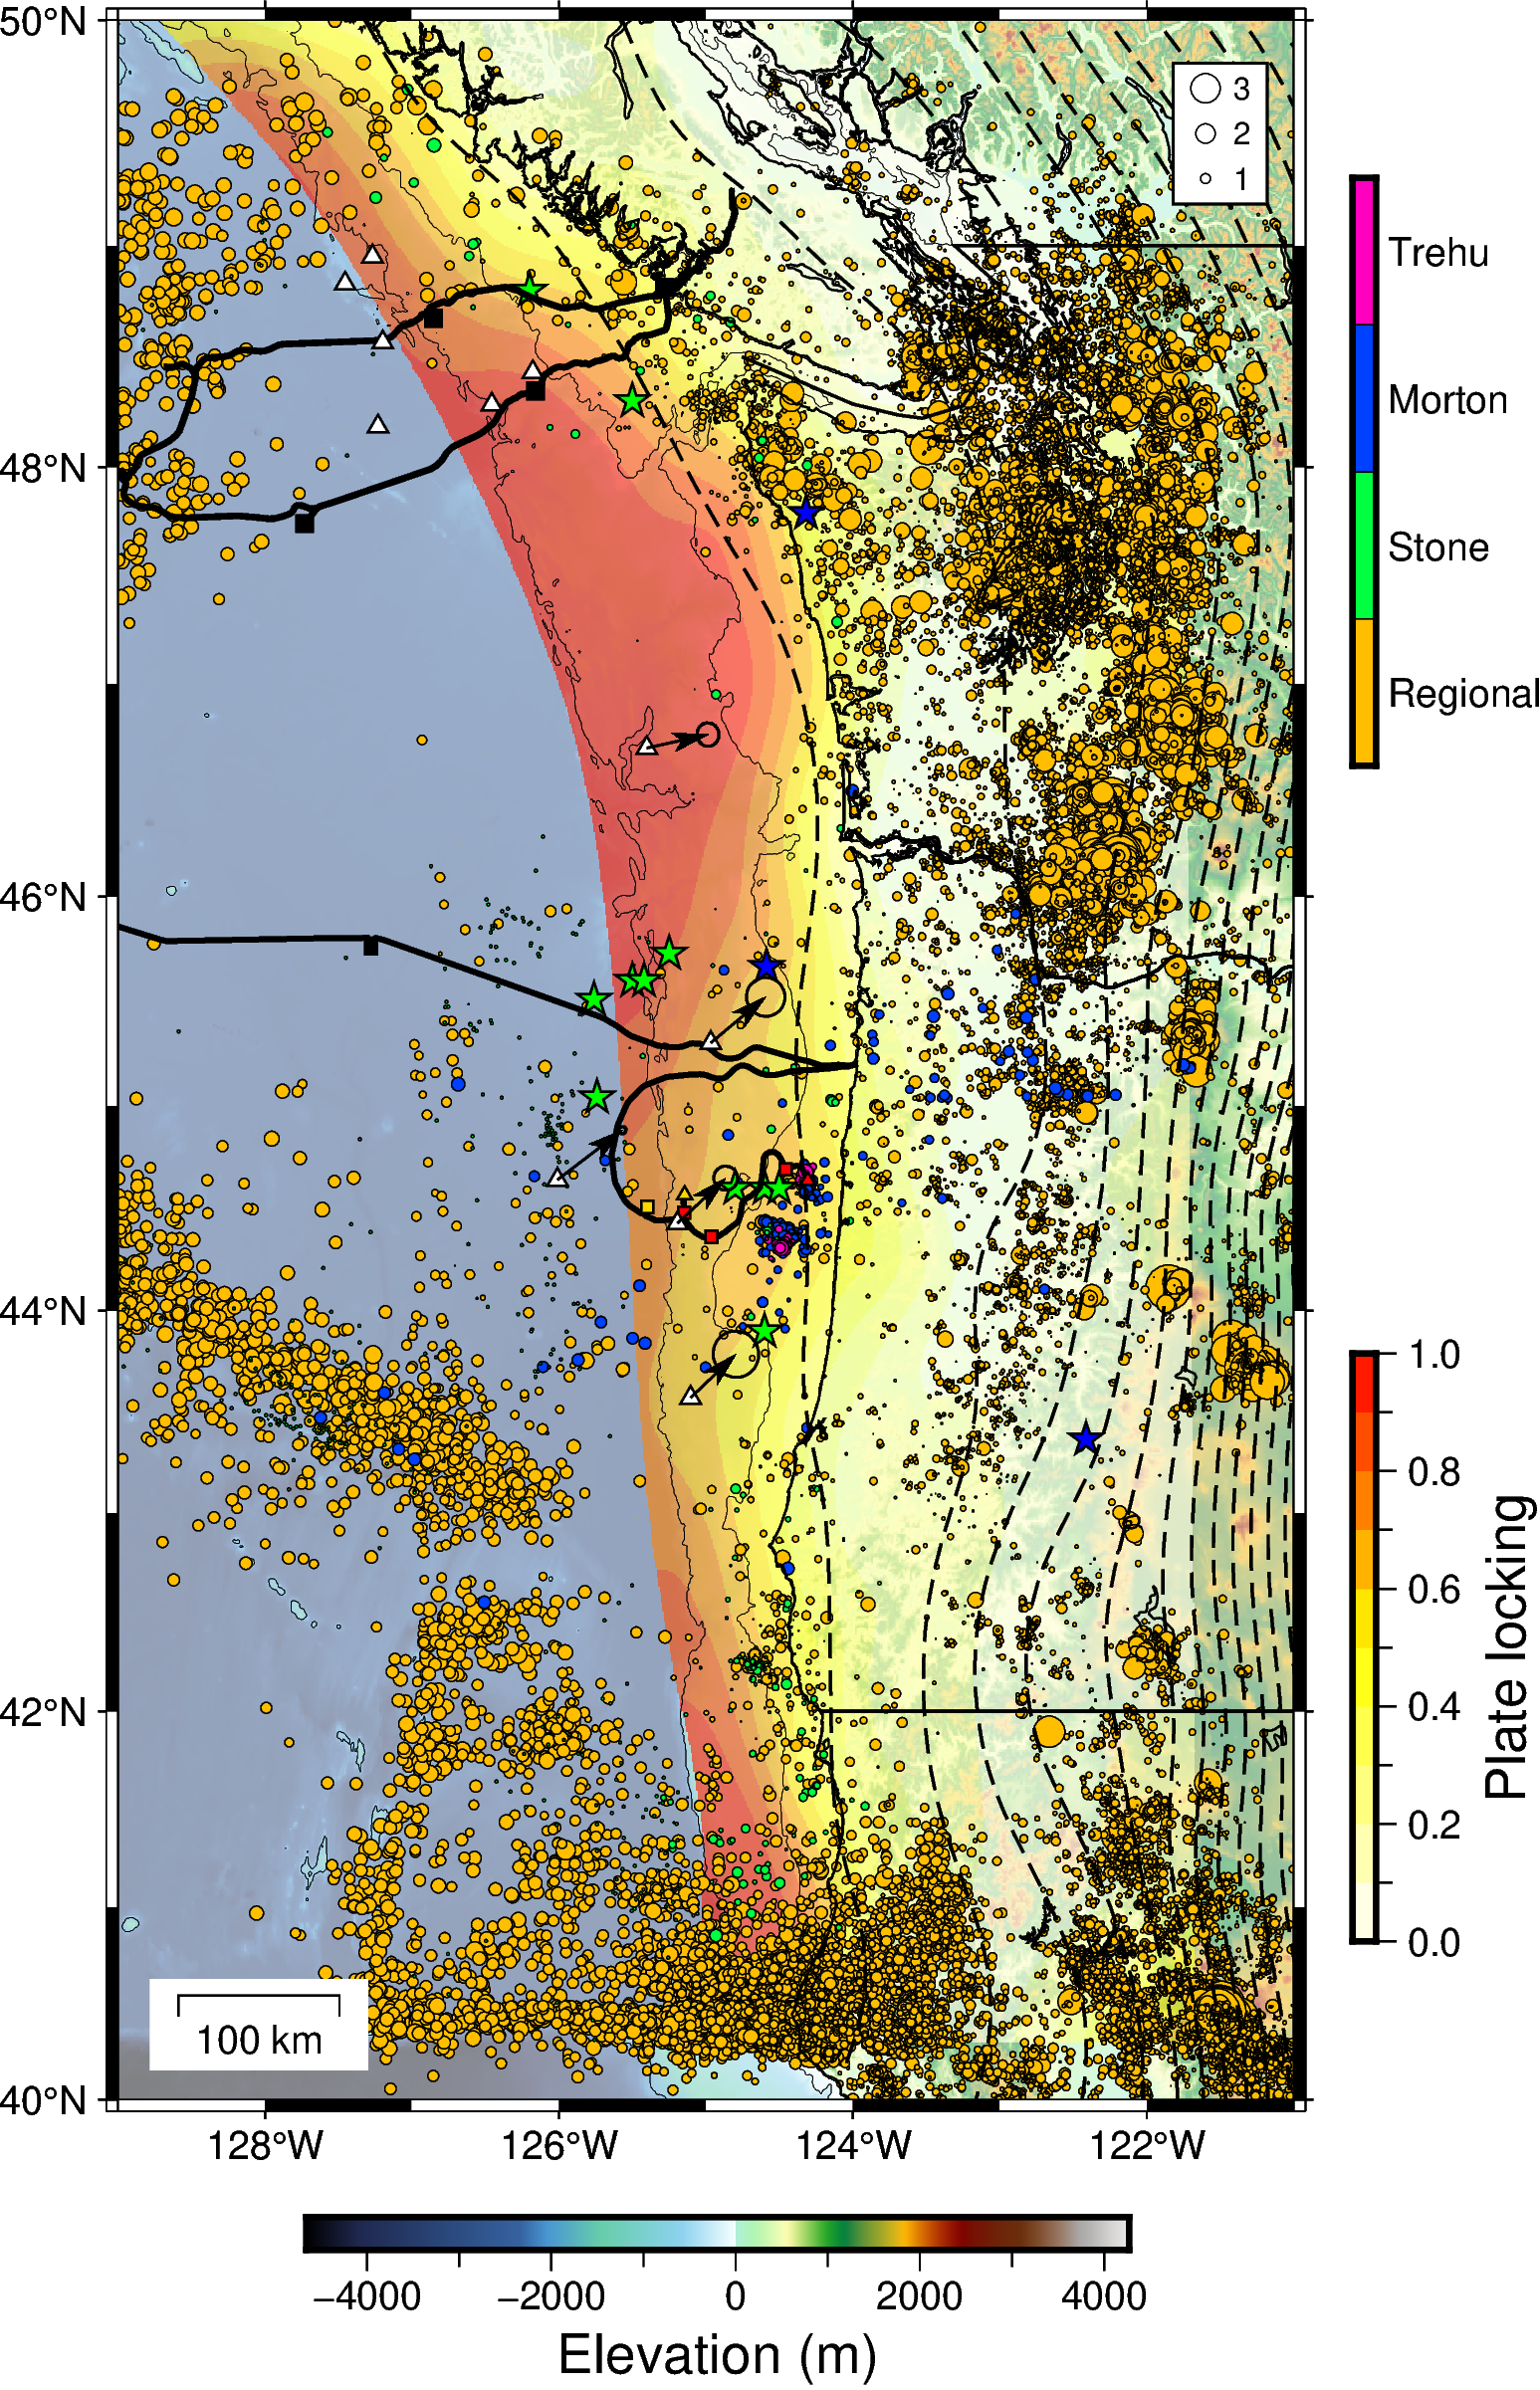

In [30]:
fig.show()

In [31]:
fig.savefig("cascadia_map.png", dpi = 400)

dyld[18743]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18744]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)


## Zoomed figure

In [32]:
osize = [o*1 for o in osize]

In [33]:
client = Client("IRIS")
starttime = UTCDateTime("2022-12-16")
endtime = UTCDateTime("2030-01-02")
sta_metadata = client.get_stations(network="UW,UO",
                                starttime = starttime,
                                endtime=endtime,
                                minlatitude=44.0, 
                                maxlatitude=45.5, 
                                minlongitude=-126, 
                                maxlongitude=-123.5)

longi=[]
lati=[]
staid=[]
for network in sta_metadata:
    for station in network:
            longi.append(station.longitude)
            lati.append(station.latitude)
            staid.append(station.code)


In [34]:
sp=['BABR','TDWTR','UCHR','ALSE','BEER','HEBO','TRASK']
both = set(staid).intersection(sp)
rest = set(staid).symmetric_difference(sp) 
ind_staid = [staid.index(x) for x in both]
ind_rest = [staid.index(x) for x in rest]
s_long=[]
s_lat=[]
r_long=[] 
r_lat=[]

for i in range(0,len(ind_staid)):
    s_long.append(longi[ind_staid[i]])
    s_lat.append(lati[ind_staid[i]])
for i in range(0,len(ind_rest)):
    r_long.append(longi[ind_rest[i]])
    r_lat.append(lati[ind_rest[i]])

In [35]:
s_long

[-123.87091,
 -123.52404,
 -123.88647,
 -123.755386,
 -123.78924,
 -123.590422,
 -123.84725]

In [36]:
fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-126, -123.5, 44.0,45.5])
fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M10c", frame="a", cmap="geo", shading=True, transparency = 50)
fig.colorbar(position = 'JMB+w7.+o0.c/1.c', frame='af+l"Elevation (m)"')

fig.grdcontour(interval=200,limit =[-220, 0],annotation=200, grid=grid)
fig.grdcontour(interval=2000,limit =[-2200, 0],annotation=2000, grid=grid)

# Plot earthquakes
pygmt.makecpt(cmap="cyclic",series='0/3/1',reverse=False,color_model='+cRegional,Stone,Morton,Trehu',verbose='q')
fig.plot(x = lon, y = lat, size = osize,color = cat_codes,cmap = True, style = "c", pen = "black")
fig.colorbar(position = 'JMR+w/4.+o0.5c/0.c')

# Plot VLFE
fig.plot(x=vlfe['Longitude'],y=vlfe['Latitude'],style="a0.3c", pen="0.5p,black", color="green")
fig.plot(x=VLFx,y=VLFy,style="a0.3c", pen="0.5p,black", color="blue")

# Plot OOI Cable
fig.plot(x=lonn1[0:333],y=latt1[0:333],pen = "1.3p,black")
fig.plot(x=lonn1[333:500],y=latt1[333:500],pen = "1.3p,black")
fig.plot(x=ooi_px[0], y=ooi_py[0], style="s0.3c", pen="0.5p,black", color="red")
fig.plot(x=ooi_px[1], y=ooi_py[1], style="s0.3c", pen="0.5p,black", color="red")
fig.plot(x=ooi_px[2], y=ooi_py[2], style="s0.3c", pen="0.5p,black", color="red")
fig.plot(x=ooi_px[3], y=ooi_py[3], style="s0.3c", pen="0.5p,black", color="black")
fig.plot(x=ins_x[0], y=ins_y[0], style="t0.3c", pen="0.5p,black", color="gold")
fig.plot(x=ins_x[1], y=ins_y[1], style="s0.3c", pen="0.5p,black", color="gold")
fig.plot(x=r_long, y=r_lat, style="t0.2c", pen="0.5p,black", color="blue")
fig.plot(x=s_long, y=s_lat, style="t0.2c", pen="0.5p,black", color="gold")
# Plot ONC cable
for coord_list in onc_coords:
    clats = [c[1] for c in coord_list]
    clons = [c[0] for c in coord_list]
    fig.plot(x=clons,y=clats,pen = "1.5p,black")
fig.plot(x=onc_px, y=onc_py, style="s0.2c", pen="0.5p,black", color="black")
fig.plot(x=GNSS_x, y=GNSS_y, style="t0.2c", pen="0.5p,black", color="white")
fig.plot(x=GNSS_xx, y=GNSS_yy, style="t0.2c", pen="0.5p,black", color="white")
fig.plot(x=lonn1[332],y=latt1[332],style="t0.3c", pen="0.5p,black", color="red")
fig.basemap(projection="M10c",region=[-126, -123.5, 44.0,45.5],map_scale="n0.1/0.075+l+c127.7/34.95+w25",box='+gwhite',frame=True)
fig.plot(
    x=-125.85,
    y=45.35,
    style="r0.8c/1.2c",  # rectangle
    color="white",  # fill color
    pen="0.6p,black",  # outline thickness and color
)
# plot legend
fig.plot(x = [-125.87], y = [45.4], size = [3/12],color = "white", style = "c", pen = "black")
fig.plot(x = [-125.87], y = [45.34], size = [2/12],color = "white", style = "c", pen = "black")
fig.plot(x = [-125.87], y = [45.29], size = [1/12],color = "white", style = "c", pen = "black")


# add annotations
fig.text(
    font="7.5p",
    text="3",
    x=[-125.8],
    y=[45.4],
)
fig.text(
    font="7.5p",
    text="2",
    x=[-125.8],
    y=[45.34],
)
fig.text(
    font="7.5p",
    text="1",
    x=[-125.8],
    y=[45.29],
)


dyld[18756]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18757]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
dyld[18758]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no suc

dyld[18782]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18783]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18784]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18785]: Library not loaded: '/usr/local/opt/net

dyld[18811]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18812]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18813]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18814]: Library not loaded: '/usr/local/opt/net

dyld[18838]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18839]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)


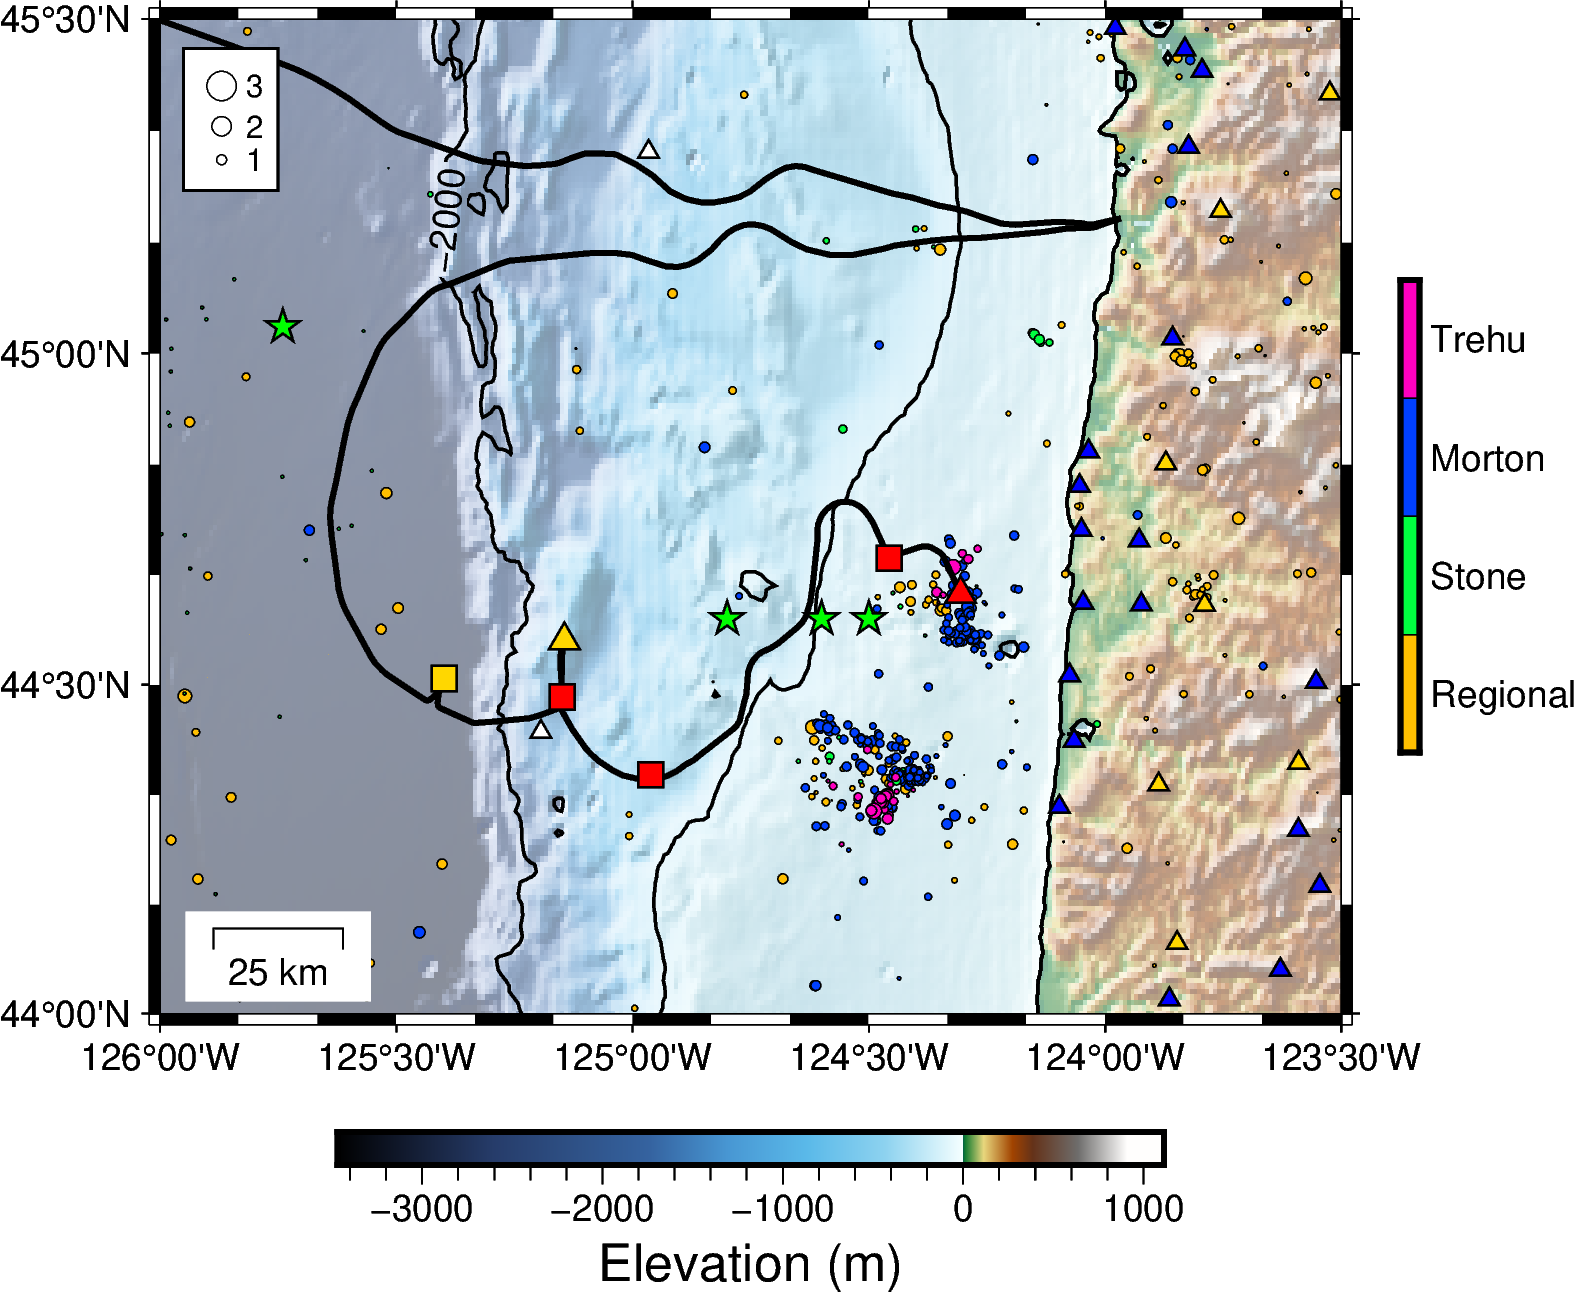

In [37]:
fig.show()

In [38]:
fig.savefig("cascadia_testmap_zoomed.png", dpi = 400)

dyld[18846]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
dyld[18847]: Library not loaded: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib'
  Referenced from: '/usr/local/Cellar/gmt/6.1.1_3/bin/gmt'
  Reason: tried: '/usr/local/opt/netcdf/lib/libnetcdf.18.dylib' (no such file), '/usr/local/lib/libnetcdf.18.dylib' (no such file), '/usr/lib/libnetcdf.18.dylib' (no such file)
